In [25]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import h5py
import os.path

import image_proc
import gt_io

import torch
import torchvision
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from craft.craft import CRAFT

In [14]:
def extendDim(tensor):
    if torch.is_tensor(tensor):
        return tensor.view((1,) + tensor.size())
    else:
        return tensor.reshape((1,) + tensor.shape)

In [17]:
class SynthCharMapDataset(Dataset):
    """SynthText Dataset + Heatmap + Direction Ground Truths"""

    def __init__(self, gt_dir, root_dir, color_flag=1, #transform=None,
                 character_map=True, affinity_map=True, direction_map=True):
        """
        Args:
            gt_dir (string): Path to gt_{i}.mat files (GT files)
            root_dir (string): Path to {j}/....jpg (folders of images)

            color_flag {1,0,-1}: Colored (1), Grayscale (0), or Unchanged (-1)
        """
        super(SynthCharMapDataset).__init__()

        self.gt_dir = gt_dir
        self.root_dir = root_dir
        self.color_flag = color_flag
        #self.transform = transform
        self.character_map = character_map
        self.affinity_map = affinity_map
        self.direction_map = direction_map

        self.length = 0
        fs = []
        for filename in os.scandir(gt_dir):
            if filename.name.endswith('.mat'):
                f = h5py.File(filename, 'r')
                fs.append(f)
                self.length += len(f['imnames'])
        self.fs = fs

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        bound = 50000
        matnum = int(idx/bound)
        imgnum = idx % bound

        f = self.fs[matnum]
        imgname = image_proc.u2ToStr(f[f['imnames'][imgnum][0]])
        charBBs = f[f['charBB'][imgnum][0]]
        txts    = f[f['txt'][imgnum][0]]

        imgpath = os.path.join(self.root_dir, imgname)
        synthetic_image = cv2.imread(imgpath, self.color_flag)
        image_shape = synthetic_image.shape[0:2]
        synthetic_image = torch.from_numpy(synthetic_image).float().cuda()
        synthetic_image = synthetic_image.view((1,3,) + image_shape)

        char_map, aff_map = image_proc.genPseudoGT(charBBs, txts, image_shape)
        if self.direction_map:
            cos_map, sin_map  = image_proc.genDirectionGT(charBBs, image_shape)

        # gt = {'char_map': char_map, 'aff_map': aff_map,
        #       'cos_map': cos_map, 'sin_map': sin_map}

        gt = None
        if self.character_map:
            gt = extendDim(char_map)
        if self.affinity_map:
            affinity_map = extendDim(affinity_map)
            if gt:
                gt = np.concatenate((gt, affinity_map))
            else:
                gt = affinity_map
        if self.direction_map:
            dir_map = np.concatenate((cos_map, sin_map))
            if gt:
                gt = np.concatenate(gt, dir_map)
            else:
                gt = dir_map
                
        #gt = np.stack((char_map, aff_map, cos_map, sin_map), axis=0)
        # print(f"gt.shape = {gt.shape}")

        # resize to match feature map size
        height, width = image_shape
        gt_shape = int(height/2), int(width/2)# problems may occur when maxpooling odd dimensions
        gt_resized = np.zeros((gt.shape[0],) + gt_shape)
        # print(f"out.shape = {gt_resized.shape}")
        for j, img in enumerate(gt):# inefficient
            gt_resized[j] = cv2.resize(img, (gt_shape[1],gt_shape[0]), interpolation=cv2.INTER_AREA)
        gt_resized = torch.from_numpy(gt_resized).float().cuda()
        gt_resized = gt_resized.view((1,) + gt_shape + (gt.shape[0],))

        return synthetic_image, gt_resized

In [33]:
gt_dir = "/home/eee198/Downloads/SynthText/matfiles"
img_dir = "/home/eee198/Downloads/SynthText/images"

# remember requires_grad=True
dataset = SynthCharMapDataset(gt_dir, img_dir, affinity_map=False, direction_map=False)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [27]:
model = CRAFT(pretrained=True, num_class=1).cuda()

In [28]:
print(f"length = {dataloader.length}")

AttributeError: 'DataLoader' object has no attribute 'length'

In [34]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

T = 10
epochs = 1
for epoch in range(epochs):
    running_loss = 0.0

    for i, (img, target) in enumerate(dataloader):
        #print(f"image shape = {img.shape}")
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output, _ = model(img)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % T == T-1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %f' % (epoch + 1, i + 1, running_loss/T))
            running_loss = 0.0

print("Finished training.")

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 461 and 338 in dimension 3 at /opt/conda/conda-bld/pytorch_1556653215914/work/aten/src/THC/generic/THCTensorMath.cu:71

In [4]:
img, gt = dataloader[0]

In [8]:
gt[0].view((4,338,600)).size()

RuntimeError: shape '[4, 338, 600]' is invalid for input of size 202800

gt shape = torch.Size([169, 300, 4])
shape = torch.Size([169, 300])
shape = torch.Size([169, 300])
shape = torch.Size([169, 300])
shape = torch.Size([169, 300])


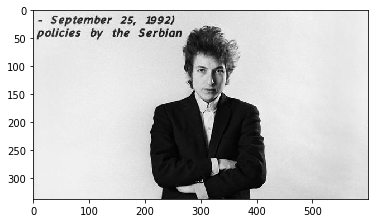

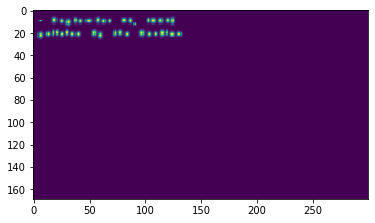

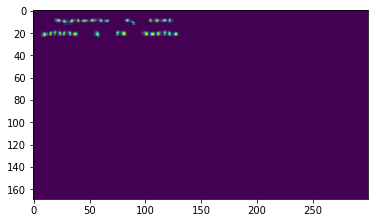

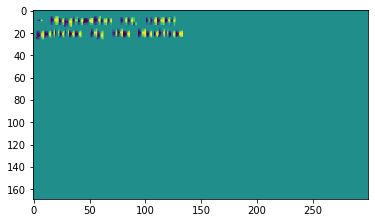

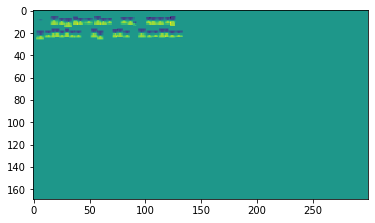

In [12]:
plt.figure()
x = img.view([338,600,3])
plt.imshow(x.cpu().numpy().astype('int'))

print(f"gt shape = {gt[0].size()}")
gt = gt[0].view([4,169,300])
for map in gt:
    print(f"shape = {map.size()}")
    plt.figure()
    plt.imshow(map.cpu().numpy())